Image dim: 70200 x 32083


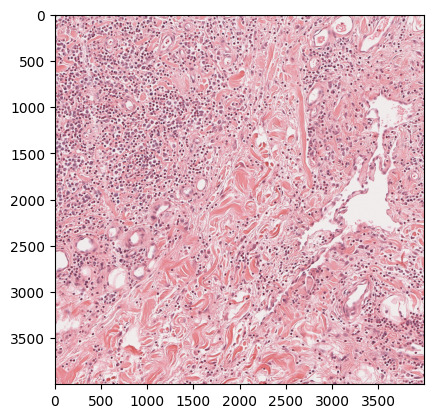

In [1]:
import os
import openslide
import matplotlib.pyplot as plt
image_path = os.path.join(os.getcwd(), "P23-5346A.svs")
slide = openslide.OpenSlide(image_path)
width, height = slide.dimensions
print(f"Image dim: {width} x {height}")
block = (4000 , 4000)
x_block = (width - block[0]) // 2
y_block = (height - block[1]) // 2
block = slide.read_region((x_block, y_block), 0, block)
block = block.convert("RGB")
plt.imshow(block)
plt.show()

Intentemos usar la imagen en escala de grises para simplificar la imagen

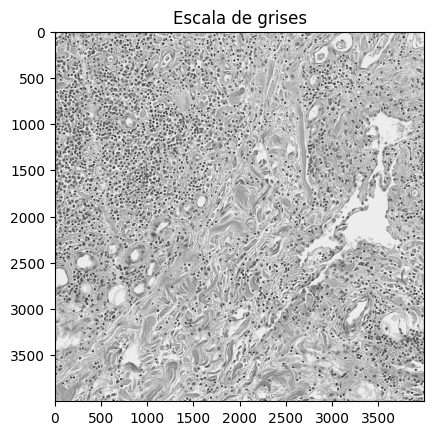

In [2]:
import cv2
import numpy as np

# Convertir el bloque de imagen a un array de NumPy para procesamiento
block_array = np.array(block)

# Convertir a escala de grises
block_gray = cv2.cvtColor(block_array, cv2.COLOR_RGB2GRAY)

plt.imshow(block_gray, cmap="gray")
plt.title("Escala de grises")
plt.show()

Hacemos equalizacion con histograma para mejorar la diferencia entre las regiones de interés y el resto de la imagen

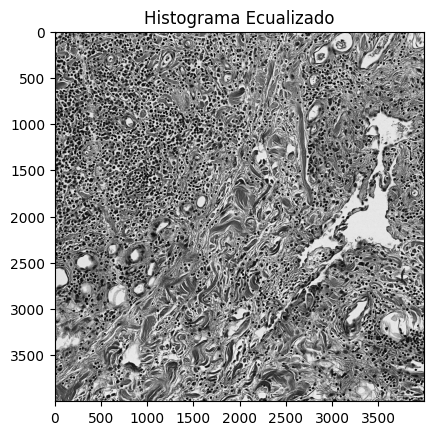

In [3]:
# Ecualización del histograma
block_eq = cv2.equalizeHist(block_gray)

plt.imshow(block_eq, cmap="gray")
plt.title("Histograma Ecualizado")
plt.show()

Filtramos el ruido de la imagen y suavizamos

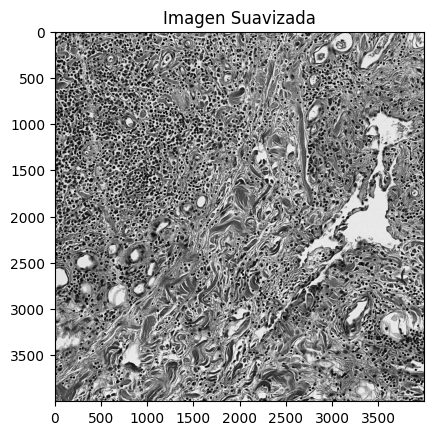

In [4]:
# Aplicar filtro Gaussiano para suavizar la imagen
block_blur = cv2.GaussianBlur(block_eq, (5, 5), 0)

plt.imshow(block_blur, cmap="gray")
plt.title("Imagen Suavizada")
plt.show()

Blob detector con una mascara basada en intensidad y [Watershed](https://en.wikipedia.org/wiki/Watershed_(image_processing)) para dividir los blobs pegados

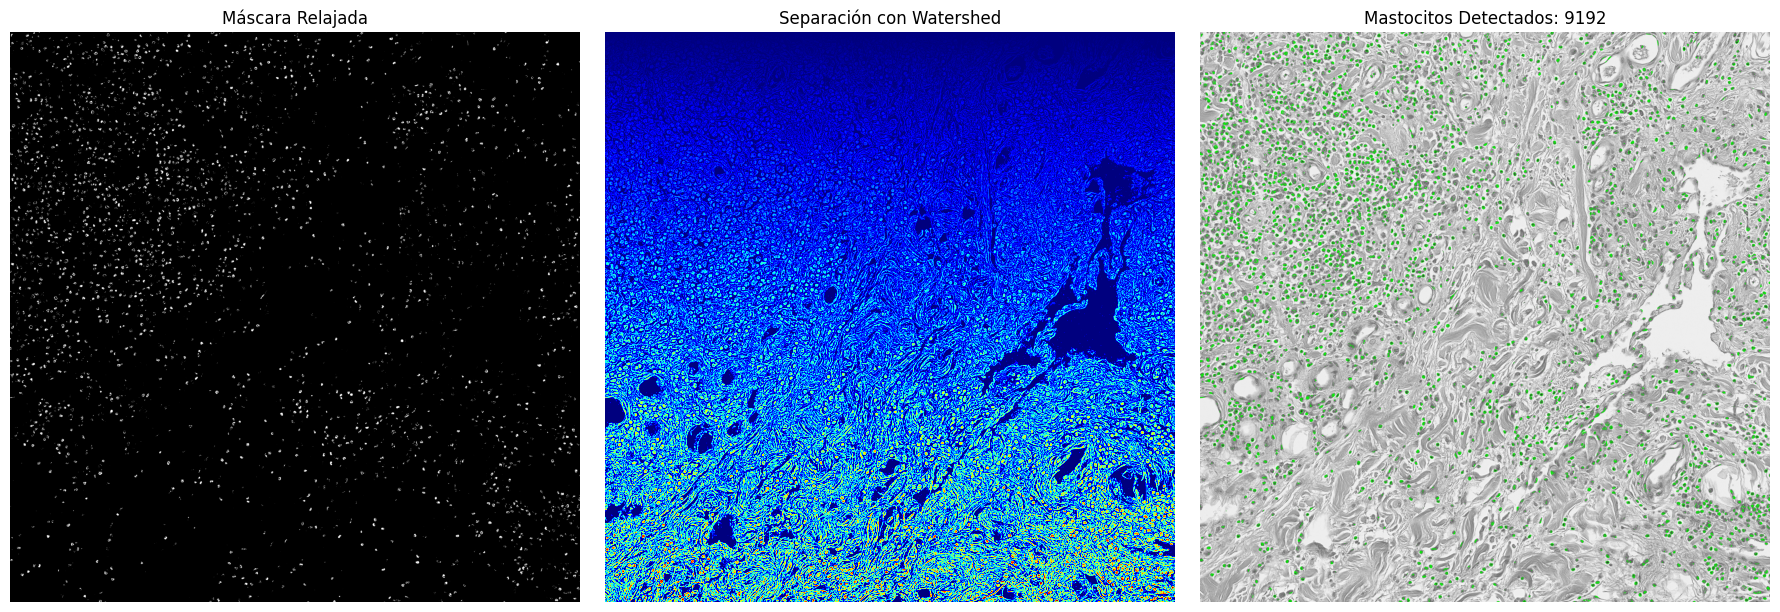

In [12]:
# Convertir a escala de grises y suavizar
if len(block_gray.shape) == 3:
    block_gray = cv2.cvtColor(block_gray, cv2.COLOR_BGR2GRAY)
smoothed = cv2.GaussianBlur(block_gray, (3, 3), 0)

# Segmentación inicial con umbralización adaptativa
binary = cv2.adaptiveThreshold(
    smoothed, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
)

# Transformada de distancia y separación de regiones foreground
distance_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(distance_transform, 0.2 * distance_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

# Detectar regiones background y áreas desconocidas
sure_bg = cv2.dilate(binary, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)), iterations=2)
unknown = cv2.subtract(sure_bg, sure_fg)

# Aplicar Watershed
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0
watershed_image = cv2.cvtColor(block_gray, cv2.COLOR_GRAY2BGR)
markers = cv2.watershed(watershed_image, markers)

# Crear una máscara final a partir de Watershed
final_mask = np.zeros_like(block_gray, dtype=np.uint8)
final_mask[markers > 1] = 255

# Relajar el filtro de intensidades
relaxed_mask = cv2.bitwise_and(final_mask, block_gray)
relaxed_mask[relaxed_mask > 80] = 0  # Incluir más intensidades oscuras
relaxed_mask[relaxed_mask > 0] = 255

# Detectar contornos y dibujar en la imagen original
contours, _ = cv2.findContours(relaxed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
output_image = cv2.cvtColor(block_gray, cv2.COLOR_GRAY2BGR)
for contour in contours:
    cv2.drawContours(output_image, [contour], -1, (0, 255, 0), 2)

# Mostrar resultados
plt.figure(figsize=(18, 6))

# Máscara final relajada
plt.subplot(1, 3, 1)
plt.imshow(relaxed_mask, cmap="gray")
plt.title("Máscara Relajada")
plt.axis("off")

# Separación con Watershed
plt.subplot(1, 3, 2)
plt.imshow(markers, cmap="jet")
plt.title("Separación con Watershed")
plt.axis("off")

# Imagen final con mastocitos detectados
plt.subplot(1, 3, 3)
plt.imshow(output_image)
plt.title(f"Mastocitos Detectados: {len(contours)}")
plt.axis("off")

plt.tight_layout()
plt.show()